In [468]:
import requests
import lxml.html as lx
import re
import time
import pickle
import numpy as np
import nltk, nltk.corpus
import plotnine as p9
#nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# create a session object
s = requests.Session()

In [472]:
# download nltk libraries
nltk.download("gutenberg")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cowma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Getting Gutenberg List of English Books

In [462]:
# get all author pages

# base URL for all requests
base_url = "https://www.gutenberg.org"

# get the authors index page
url = f"{base_url}/browse/authors/"
response = s.get(url)
doc = lx.fromstring(response.content)

# get all author links ending with .utf8
author_links = [link for link in doc.xpath('//a/@href') if link.endswith('.utf8')]

# convert relative URLs to absolute URLs, ensuring /browse/authors/ is included
author_pages = [link if link.startswith("/browse/authors/") else base_url + "/browse/authors/" + link for link in author_links]

In [462]:
# get all english books from each author page

author_books_dict = {}

for author_url in author_pages:
    time.sleep(1)
    # print(f"Processing {author_url}") #track progress
    response = s.get(author_url)

    if response.status_code == 200:
        doc = lx.fromstring(response.content)

        books = []

        # find all <ul> elements that contain books
        # iterate over each <h2> tag (authors) and their associated <ul> of books
        for h2 in doc.xpath('//h2'):
            # author (first <a> inside <h2>)
            author_name = h2.xpath('.//a[1]/text()')

            # extract as string, not list
            if author_name:
                author_name = author_name[0].strip()
                if not author_name: 
                    continue
            else:
                continue

            # find all <ul> elements that follow this <h2> tag and contain books
            ul_elements = h2.xpath('following-sibling::ul[1]')
            for ul in ul_elements:
                for li in ul.xpath('.//li[@class="pgdbetext"]'):
                    link = li.find('a')  # Get the first <a> tag inside the <li>
                    if link is not None:
                        href = link.get('href', '')
                        text = li.text_content().strip()

                        # remove line breaks and whitespace
                        cleaned_text = " ".join(text.splitlines()).strip()
                        
                        # check for "(English) (as Author)" and remove it before adding
                        if "(English) (as Author)" in cleaned_text:
                            cleaned_text = re.sub(r' \(English\) \(as Author\)$', '', cleaned_text).strip()

                            # href matches '/ebooks/[numbers]'
                            if re.match(r'^/ebooks/\d+$', href):
                                full_ebook_url = base_url + href
                                books.append({'title': cleaned_text, 'link': full_ebook_url})
                        else:
                            continue

            if books:
                # check that author_name is valid
                try:
                    # if exists, append the books. otherwise add
                    if author_name in author_books_dict:
                        author_books_dict[author_name].extend(books)
                    else:
                        author_books_dict[author_name] = books
                except TypeError as e:
                    print(f"Error adding books for '{author_name}': {e}") # catch errors
                books = []  # reset for next author

    else:
        print(f"Failed to retrieve {author_url}, status code: {response.status_code}")

In [437]:
# Save
with open("data/author_books_dict.pkl", "wb") as f:
    pickle.dump(author_books_dict, f)

In [439]:
# Load
with open("data/author_books_dict.pkl", "rb") as f:
    author_books_dict = pickle.load(f)

In [8]:
# fix the author name data to be split properly

def process_book_data(book_data):
    processed_data = {}

    for author, books in book_data.items():
        if '(' in author and ')' in author:
            # handle initials with full name in parentheses
            match = re.match(r'([^,]+), ([A-Za-z\. ]+)(?: \(([^)]+)\))?, (\d{4})(?:-(\d{4}))?', author)
            
            if match:
                last_name = match.group(1).strip()
                first_name = match.group(2).strip()
                full_first_name = match.group(3)
                birth_year = match.group(4) or "Unknown"
                death_year = match.group(5) or "Unknown"

                # keep initials, ignore full name in parentheses
                author_key = f"{last_name}, {first_name}"

                processed_data[author_key] = {
                    "first_name": first_name,
                    "last_name": last_name,
                    "birth_year": birth_year,
                    "death_year": death_year,
                    "books": books
                }
        else:
            # handle normal case with no parentheses
            match = re.match(r'([^,]+), ([A-Za-z ]+)(?:, (\d{4})(?:-(\d{4}))?)?', author)

            if match:
                last_name = match.group(1).strip()
                first_name = match.group(2).strip().split()[0]  # take first first name
                birth_year = match.group(3) or "Unknown"
                death_year = match.group(4) or "Unknown"

                author_key = f"{last_name}, {first_name}"

                processed_data[author_key] = {
                    "first_name": first_name,
                    "last_name": last_name,
                    "birth_year": birth_year,
                    "death_year": death_year,
                    "books": books
                }
    
    return processed_data

# fix author names
gutenberg_books = process_book_data(author_books_dict)

## Finding Goodreads Books with Genre Search and Mapping to Gutenberg

In [10]:
# get goodreads data
# requires cookie and agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36',
    'Cookie': 'ccsid=687-6983670-8558500; blocking_sign_in_interstitial=true; locale=en; _session_id2=59f96fd4c8c0b150bb8ab35dd85b3c8c; csm-sid=192-5347309-7060261'
}

s.headers.update(headers)

def get_books_by_genre(genre_name):
    url = f"https://www.goodreads.com/shelf/show/{genre_name}"
    response = s.get(url)
    print(url)
    if response.status_code != 200:
        return []

    response.encoding = 'utf-8'  # to catch weird apostrophes in some titles
    tree = lx.fromstring(response.text)
    books = tree.xpath('//div[@class="left"]')

    book_list = []
    
    for book in books:
        title_tag = book.xpath('.//a[@class="bookTitle"]')
        title = title_tag[0].text.strip() if title_tag else "Unknown"
        title = re.sub(r'\(.*\)', '', title).strip().replace("’", "'")

        author_tag = book.xpath('.//a[@class="authorName"]/span')
        author = author_tag[0].text.strip() if author_tag else "Unknown"

        # split author name into first and last names
        author_parts = author.rsplit(' ', 1)  # split on the last space character
        if len(author_parts) == 2:
            first_name, last_name = author_parts
        else:
            first_name = author  # if no space, the whole name is the first name
            last_name = ""

        publication_tag = book.xpath('.//span[@class="greyText smallText"]')
        publication = publication_tag[0].text.strip() if publication_tag else "Unknown"
        
        # regex for year
        publication_year = re.search(r'published[^\d]*(-?\d+)', publication)  # to catch approximated dates eg -492
        publication_year = publication_year.group(1) if publication_year else "Unknown"

        book_list.append({
            'title': title,
            'first_name': first_name,
            'last_name': last_name,
            'publication_year': publication_year
        })

    return book_list

# check for books in goodreads list that are on gutenberg
def match_books_with_gutenberg(goodreads_books, gutenberg_data):
    matched_books = []

    for book in goodreads_books:
        # get first name, last name, title, and tag
        first_name = book['first_name']
        last_name = book['last_name']
        book_title = book['title']
        tag = book['tag']  # get tag

        # construct author key to match gutenberg format
        author_key = f"{last_name}, {first_name}"

        # check if author exists in gutenberg data
        if author_key in gutenberg_data:
            gutenberg_info = gutenberg_data[author_key]

            # find matching books by title
            matching_books = []
            for gutenberg_book in gutenberg_info['books']:
                if gutenberg_book['title'] == book_title:
                    matching_books.append(gutenberg_book)

            # if multiple matches, select one with lowest book ID
            if matching_books:
                # sort by book ID
                matching_books.sort(key=lambda x: int(re.search(r'ebooks/(\d+)', x['link']).group(1)))

                selected_book = matching_books[0]

                # add matched book with tag to result
                matched_book = {
                    'title': book['title'],
                    'first_name': first_name,
                    'last_name': last_name,
                    'publication_year': book['publication_year'],
                    'gutenberg_books': [selected_book],
                    'birth_year': gutenberg_info['birth_year'],
                    'death_year': gutenberg_info['death_year'],
                    'tag': tag # book genre search tag
                }
                matched_books.append(matched_book)

    return matched_books

# function to group books by genres
# handles multiple genres
def group_books_by_tags_and_add_tag(genre_list, tag_name):
    all_books = []
    seen_books = set()

    for genre in genre_list:
        genre_books = get_books_by_genre(genre)
        time.sleep(1)

        for book in genre_books:
            book_identifier = f"{book['title']} - {book['first_name']} {book['last_name']}"

            if book_identifier not in seen_books:
                seen_books.add(book_identifier)

                book_info = {
                    'title': book['title'],
                    'first_name': book['first_name'],
                    'last_name': book['last_name'],
                    'publication_year': book['publication_year'],
                    'tag': tag_name
                }

                all_books.append(book_info)

    return all_books

In [12]:
# get difficult books
difficult_tags = ["difficult"]
difficult_books = group_books_by_tags_and_add_tag(difficult_tags, "difficult")
matched_books = match_books_with_gutenberg(difficult_books, gutenberg_books)

https://www.goodreads.com/shelf/show/difficult


## Getting Books from Gutenberg Genre Pages

In [14]:
def scrape_gutenberg_subjects(start_url, max_pages=5):
    scraped_data = []
    current_page = 1
    next_page_url = start_url

    while next_page_url and current_page <= max_pages:
        print(f"--- Scraping Page {current_page} ---")

        response = s.get(next_page_url)
        if response.status_code != 200:
            print(f"Failed to fetch {next_page_url}")
            break

        # parse
        tree = lx.fromstring(response.content)

        # extract genre info
        subjects = tree.xpath('//li[@class="navlink"]')
        for subject in subjects:
            link_element = subject.xpath('.//a[@class="link"]')[0]
            genre_link = base_url + link_element.get("href")
            genre_title = subject.xpath('.//span[@class="title"]/text()')[0].strip()
            downloads = subject.xpath('.//span[@class="extra"]/text()')
            downloads = downloads[0].strip() if downloads else "N/A"

            scraped_data.append({
                "genre": genre_title,
                "link": genre_link,
                "downloads": downloads
            })

        # find "Next" page link
        next_page = tree.xpath('//a[@title="Go to the next page of results."]/@href')
        next_page_url = base_url + next_page[0] if next_page else None

        # next page
        current_page += 1
        time.sleep(1)

    return scraped_data

def get_books_from_subjects(scraped_subjects, genres_to_search, max_books=10):
    books_data = []
    seen_pages = set()  # tracks processed pages

    for subject in scraped_subjects:
        subject_genre = subject["genre"].lower()

        genre_matched = False

        for genre in genres_to_search:
            genre_lower = genre.lower()

            # find the first matching genre
            if genre_lower in subject_genre and subject["link"] not in seen_pages:
                print(f"--- Fetching books from: {subject['genre']} ---")

                seen_pages.add(subject["link"])

                response = s.get(subject["link"])

                tree = lx.fromstring(response.content)
                book_elements = tree.xpath('//a[@class="link"]')
                seen_authors = set()
                books_found = 0

                for book in book_elements:
                    if books_found >= max_books:
                        break  # stop after reaching max books

                    book_link = base_url + book.get("href")
                    title = book.xpath('.//span[@class="title"]/text()')
                    author = book.xpath('.//span[@class="subtitle"]/text()')

                    if title and author:
                        title = title[0].strip()
                        author = author[0].strip()

                        if author not in seen_authors:
                            seen_authors.add(author)
                            books_data.append({
                                "genre": subject["genre"],
                                "title": title,
                                "author": author,
                                "link": book_link
                            })
                            books_found += 1

                genre_matched = True
                break  # stop checking other genres for this subject

        if not genre_matched:
            continue  # skip subjects with no match

    return books_data

def get_books_from_subjects(scraped_subjects, genres_to_search, max_books=10):
    books_data = []
    seen_pages = set()  # tracks processed pages

    for subject in scraped_subjects:
        subject_genre = subject["genre"].lower()

        genre_matched = False

        for genre in genres_to_search:
            genre_lower = genre.lower()

            # check if genre matches and page hasn't been processed
            if genre_lower in subject_genre and subject["link"] not in seen_pages:
                seen_pages.add(subject["link"])  # mark page as processed

                # request the subject page
                response = s.get(subject["link"])

                # parse HTML content
                tree = lx.fromstring(response.content)

                # extract book elements
                book_elements = tree.xpath('//a[@class="link"]')
                seen_authors = set()
                books_found = 0

                for book in book_elements:
                    if books_found >= max_books:
                        break  # stop if max books are reached

                    book_link = base_url + book.get("href")
                    title = book.xpath('.//span[@class="title"]/text()')
                    author = book.xpath('.//span[@class="subtitle"]/text()')

                    if title and author:
                        title = title[0].strip()
                        author = author[0].strip()

                        if author not in seen_authors:
                            seen_authors.add(author)
                            books_data.append({
                                "link": book_link,
                                "tag": genre  # genre name
                            })
                            books_found += 1

                genre_matched = True
                break  # stop after first genre match

        if not genre_matched:
            continue  # skip if no genre match

    return books_data

def match_books_with_gutenberg(gutenberg_books, books_from_subjects):
    matched_books = []

    for book in books_from_subjects:
        # get book link and tag
        book_link = book['link']
        tag = book['tag']

        # find matching books in gutenberg data
        for author, author_info in gutenberg_books.items():
            # check for matching books by link
            for gutenberg_book in author_info['books']:
                if gutenberg_book['link'] == book_link:
                    matched_book = {
                        'title': gutenberg_book['title'],
                        'first_name': author_info['first_name'],
                        'last_name': author_info['last_name'],
                        'birth_year': author_info['birth_year'],
                        'death_year': author_info['death_year'],
                        'gutenberg_books': [gutenberg_book],
                        'tag': tag  # genre tag
                    }
                    matched_books.append(matched_book)
                    break  # stop after first match

    return matched_books

def merge_books_and_format(matched_books, matched_gutenberg_books):
    # get set of titles from matched_books and matched_gutenberg_books
    matched_books_titles = {book['title'] for book in matched_books}
    matched_gutenberg_books_titles = {book['title'] for book in matched_gutenberg_books}

    # remove books with matching titles from both lists
    matched_books = [book for book in matched_books if book['title'] not in matched_gutenberg_books_titles]
    matched_gutenberg_books = [book for book in matched_gutenberg_books if book['title'] not in matched_books_titles]

    # Format matched_books to match the structure of matched_gutenberg_books
    formatted_matched_books = []
    for book in matched_books:
        formatted_book = {
            'title': book['title'],
            'first_name': book['first_name'],
            'last_name': book['last_name'],
            'birth_year': book['birth_year'],
            'death_year': book['death_year'],
            'gutenberg_books': [{'title': book['title'], 'link': book['gutenberg_books'][0]['link']}],
            'tag': book['tag']
        }
        formatted_matched_books.append(formatted_book)

    # Combine the two lists
    combined_books = matched_gutenberg_books + formatted_matched_books

    return combined_books

In [16]:
# Set start URL and max pages to scrape
start_url = f"{base_url}/ebooks/subjects/search/?sort_order=downloads"
scraped_subjects = scrape_gutenberg_subjects(start_url, max_pages=5)

--- Scraping Page 1 ---
--- Scraping Page 2 ---
--- Scraping Page 3 ---
--- Scraping Page 4 ---
--- Scraping Page 5 ---


In [18]:
# search for books using gutenbergs genres
genres_to_search = [
    "science fiction", "horror", "love", "historical", "fairy tales", "classic", "philosophy"
]
books_from_subjects = get_books_from_subjects(scraped_subjects, genres_to_search, max_books=10)

matched_gutenberg_books = match_books_with_gutenberg(gutenberg_books, books_from_subjects)

In [20]:
# merge and format the gutenberg books with the goodreads books we looked up
combined_books = merge_books_and_format(matched_books, matched_gutenberg_books)

## Gathering Gutenberg Metadata, Text, and Cleaning Text

In [24]:
# add metadata to books
def add_metadata_to_books(author_books_list):
    # loop over each book in the list
    for book in author_books_list:
        book_url = book['gutenberg_books'][0]['link']  # Assuming each book has one link

        try:
            # request book metadata
            response = s.get(book_url)
            if response.status_code != 200:
                print(f"failed to retrieve {book_url}")
                continue
            
            doc = lx.fromstring(response.content)
            read_online_link = doc.xpath('//a[text()="Read online (web)"]/@href')
            
            # add read online link
            book['gutenberg_books'][0]['read_online_link'] = f"https://www.gutenberg.org{read_online_link[0]}" if read_online_link else None
            
            metadata = {}
            # extract metadata from rows
            for row in doc.xpath('//div[@id="bibrec"]//table//tr'):
                key = row.xpath('.//th/text()')
                value = " ".join(row.xpath('.//td//text()')).strip() if row.xpath('.//td') else ""

                if key:
                    key = key[0].strip()
                    # handle reading ease score and difficulty
                    if key == "Note" and "Reading ease score: " in value:
                        try:
                            score, difficulty = value.split(" (", 1)
                            metadata["reading_ease_score"] = float(score.split(": ")[1])
                            metadata["reading_difficulty"] = difficulty.replace("(", "").replace(")", "").strip()
                        except ValueError:
                            pass
                    elif key == "LoC Class":
                        metadata["loc_class"] = value
                    elif key == "Release Date":
                        metadata["release_date"] = value
                    elif key == "Downloads":
                        metadata["downloads"] = value
            
            # update book with metadata
            book.update(metadata)
            # add default values if not available
            book.setdefault("reading_ease_score", "Not available")
            book.setdefault("reading_difficulty", "Not available")

        except Exception as e:
            print(f"error processing {book_url}: {e}")
    
    return author_books_list


# fetch book text
def add_book_text(author_books_list):
    for book in author_books_list:
        if 'read_online_link' in book['gutenberg_books'][0] and book['gutenberg_books'][0]['read_online_link']:
            try:
                response = s.get(book['gutenberg_books'][0]['read_online_link'])
                if response.status_code != 200:
                    print(f"failed to retrieve {book['gutenberg_books'][0]['read_online_link']}")
                    continue
                
                doc = lx.fromstring(response.content)
                book_text = " ".join(doc.xpath('//body//text()')).strip()
                book['text'] = book_text

            except Exception as e:
                print(f"error processing {book['gutenberg_books'][0]['read_online_link']}: {e}")

    return author_books_list


# extract book text between gutenberg markers
def extract_gutenberg_text(full_text):
    start_match = re.search(r"(?i)\*{3}\s*start\s*of\s*(?:the\s*)?(?:project\s*gutenberg\s*)?(?:etext|ebook)", full_text)
    end_match = re.search(r"(?i)\*{3}\s*end\s*of\s*(?:the\s*)?(?:project\s*gutenberg\s*)?(?:etext|ebook)", full_text)

    if not start_match or not end_match:
        print("Text markers not found.")
        return None

    return full_text[start_match.end():end_match.start()].strip()


# clean all books
def clean_all_books(book_data):
    cleaned_books = []
    
    for book in book_data:
        cleaned_text = extract_gutenberg_text(book.get('text', ''))
        if cleaned_text:
            cleaned_books.append({
                "first_name": book["first_name"],
                "last_name": book["last_name"],
                "birth_year": book["birth_year"],
                "death_year": book["death_year"],
                "title": book.get('title', 'N/A'),
                "read_online_link": book["gutenberg_books"][0].get('read_online_link', 'N/A') if "gutenberg_books" in book and book["gutenberg_books"] else "N/A",
                "reading_ease_score": book.get("reading_ease_score", "Not available"),
                "reading_difficulty": book.get("reading_difficulty", "Not available"),
                "loc_class": book.get('loc_class', 'N/A'),
                "release_date": book.get('release_date', 'N/A'),
                "downloads": book.get('downloads', 'N/A'),
                "tag": book.get('tag', 'N/A'),
                "cleaned_text": cleaned_text
            })
    
    return cleaned_books

In [36]:
# set books to check
filtered_books = combined_books

print("\n--- Step 1: Adding Metadata to Books ---")
processed_data = add_metadata_to_books(filtered_books)

print("\n--- Step 2: Fetching Book Text ---")
processed_data = add_book_text(processed_data)

print("\n--- Step 3: Cleaning All Books ---")
cleaned_books = clean_all_books(processed_data)

print("\n--- Process Complete! ---")



--- Step 1: Adding Metadata to Books ---

--- Step 2: Fetching Book Text ---

--- Step 3: Cleaning All Books ---

--- Process Complete! ---


In [70]:
cleaned_books_unclean = cleaned_books

In [405]:
# remove duplicates (e.g. Grimm's Fairy Stories appears twice because two authors)
seen_titles = set()
cleaned_books = []

for book in cleaned_books_unclean:
    title = book['title']
    if title not in seen_titles:
        cleaned_books.append(book)
        seen_titles.add(title)

In [441]:
# Save
with open("data/cleaned_books.pkl", "wb") as f:
    pickle.dump(cleaned_books, f)

In [443]:
# Load
with open("data/cleaned_books.pkl", "rb") as f:
    cleaned_books = pickle.load(f)

## Ngram Data Gathering and Manipulation

In [105]:
def extract_top_words_multiple(books_dict):
    stopwords = set(nltk.corpus.stopwords.words("english"))
    updated_books = []
    
    for book in books_dict:
        words = re.findall(r"[a-zA-Z\-\'’]{2,}|[aAiI]", book['cleaned_text'])
        words = [re.sub(r"\'s$|’s$|s’$|s\'$", "", word) for word in words]
        words = [w.lower() for w in words if w.lower() not in stopwords]

        fq = nltk.FreqDist(words)
        lastind = len(fq) - (len(fq) // 20)
        top_words = [x[0] for x in fq.most_common(lastind)[lastind-20:lastind]]

        new_book = {k: v for k, v in book.items() if k != 'cleaned_text'}
        new_book['top_words'] = top_words

        updated_books.append(new_book)

    return updated_books

In [107]:
ngrams_books = extract_top_words_multiple(cleaned_books)

In [450]:
def search_by_title(title, books):
    result = []
    for book in books:
        if title.lower() in book['title'].lower():
            result.append(book)
    return result

# check an entry (for exploration)
# title_to_search = 'The Story of the Three Little Pigs'
# search_by_title(title_to_search, ngrams_books)

In [403]:
def get_ngram_data(corpus, ngram, case_sensitive=False, collapse_results=False):
    base_url = "https://api.ngrams.dev"
    query = ngram.replace(" ", "+")
    flags = ""

    if case_sensitive:
        flags = "cs"
    if collapse_results:
        flags = "cr"

    url = f"{base_url}/{corpus}/search?query={query}"
    if flags:
        url += f"&flags={flags}"

    response = s.get(url)
    
    if response.status_code != 200:
        print(f"Request failed with status code {response.status_code}")
        return None

    data = response.json()

    if not data.get("ngrams"):
        print("No ngrams found.", ngram)
        return None

    return data.get("ngrams")[0]


def get_ngram_stats(corpus, ngrams, min_year=1800):
    # dictionary to store aggregated relMatchCount by year
    year_match_counts = {}
    most_recent_year = None
    highest_year_match = None
    highest_year_match_count = 0

    for ngram in ngrams:
        # get n-gram probability data for each word
        ngram_data = get_ngram_data(corpus, ngram)
        if not ngram_data:
            continue

        ngram_id = ngram_data["id"]
        base_url = "https://api.ngrams.dev"
        url = f"{base_url}/{corpus}/{ngram_id}"

        response = s.get(url)

        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}")
            return None

        data = response.json()

        if "stats" not in data or not data["stats"]:
            print("No stats found.")
            continue

        stats = data["stats"]

        for stat in stats:
            year = stat["year"]
            rel_match = stat["relMatchCount"]

            # filter out years before min_year
            if year < min_year:
                continue

            # aggregate relMatchCount by year
            if year in year_match_counts:
                year_match_counts[year] += rel_match
            else:
                year_match_counts[year] = rel_match

            # track the highest relMatchCount year
            if year_match_counts[year] > highest_year_match_count:
                highest_year_match = stat
                highest_year_match_count = year_match_counts[year]

            # track the most recent year
            if most_recent_year is None or year > most_recent_year["year"]:
                most_recent_year = stat

    result = {
        "totalRelMatchCount": sum(year_match_counts.values()),  # sum of relMatchCounts
        "highestYearMatch": highest_year_match,
        "mostRecentRelMatch": most_recent_year
    }

    return result

def get_ngram_stats_for_books(ngrams_books, corpus="eng", min_year=1800):
    results = []

    for book in ngrams_books:
        top_words = book.get("top_words", [])
        
        if top_words:
            ngram_stats = get_ngram_stats(corpus, top_words, min_year)
            
            if ngram_stats:
                book_data = book.copy()  # avoid modifying the original
                book_data["ngram_stats"] = ngram_stats
                results.append(book_data)
            else:
                book_data = book.copy()
                book_data["ngram_stats"] = None
                results.append(book_data)
        else:
            book_data = book.copy()
            book_data["ngram_stats"] = None
            results.append(book_data)
    
    return results

In [127]:
processed_books = get_ngram_stats_for_books(ngrams_books, corpus="eng", min_year=1700)

In [445]:
# Save
with open("data/ngram_processed_books.pkl", "wb") as f:
    pickle.dump(processed_books, f)

In [447]:
# Load
with open("data/ngram_processed_books.pkl", "rb") as f:
    processed_books = pickle.load(f)

## Visualizing Ngram Results

In [431]:
#  all visualization functions
def visualize_ngram_stats_by_birth_span(ngrams_books):
    # prepare lists to store the data
    birth_years = []
    total_match_counts = []

    # extract data from the books
    for book in ngrams_books:
        birth_year_str = book.get("birth_year", "Unknown")

        # handle invalid birth years
        try:
            birth_year = int(birth_year_str)
        except ValueError:
            # set birth_year to a default value if it's invalid (e.g., 0 or skip it)
            birth_year = 0  # or you could choose a different default year

        ngram_stats = book.get("ngram_stats", {})

        # extract ngram statistics
        if ngram_stats:
            total_rel_match = ngram_stats.get("totalRelMatchCount", 0)

            # append data
            birth_years.append(birth_year)
            total_match_counts.append(total_rel_match)

    # create DataFrame for better visualization handling
    data = pd.DataFrame({
        "Birth Year": birth_years,
        "Total RelMatch Count": total_match_counts
    })

    # function to assign authors to birth year buckets
    def assign_birth_span(year):
        if year < 1750:
            return "Before 1750"
        elif 1750 <= year <= 1774:
            return "1750-1774"
        elif 1775 <= year <= 1799:
            return "1775-1799"
        elif 1800 <= year <= 1824:
            return "1800-1824"
        elif 1825 <= year <= 1849:
            return "1825-1849"
        elif 1850 <= year <= 1874:
            return "1850-1874"
        elif 1875 <= year <= 1899:
            return "1875-1899"
        elif 1900 <= year <= 1924:
            return "1900-1924"
        elif 1925 <= year <= 1949:
            return "1925-1949"
        else:
            return "1950 and after"

    # apply the function to categorize birth year
    data['Birth Span'] = data['Birth Year'].apply(assign_birth_span)

    # calculate average relmatch count by birth span
    birth_span_avg_match_data = data.groupby('Birth Span').agg({'Total RelMatch Count': 'mean'}).reset_index()

    # set order to place "Before 1750" on the left
    birth_span_order = [
        "Before 1750", "1750-1774", "1775-1799", "1800-1824", "1825-1849", 
        "1850-1874", "1875-1899", "1900-1924", "1925-1949", "1950 and after"
    ]

    # plot the average total relmatch count by birth span
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Birth Span", y="Total RelMatch Count", data=birth_span_avg_match_data, 
                color="skyblue", order=birth_span_order)
    plt.title('Average Total Relative Ngram Matches Across Author Birth Year')
    plt.ylabel('Average Total Relative Ngram Match Count')
    plt.xlabel('Author Birth Year Span')
    
    plt.tight_layout()

    # save the plot as a PNG file
    plt.savefig("results/scatter_plot_birth_year_vs_relmatch.png", format='png', dpi=300)
    
    plt.show()

def visualize_ngram_stats(ngrams_books):
    # prepare lists to store the data
    titles = []
    genres = []
    highest_years = []
    highest_year_matches = []
    recent_years = []
    recent_match_counts = []
    total_match_counts = []

    # extract data from the books
    for book in ngrams_books:
        title = book.get("title", "Unknown")
        genre = book.get("tag", "Unknown")
        ngram_stats = book.get("ngram_stats", {})

        # extract ngram statistics
        if ngram_stats:
            highest_year_match = ngram_stats.get("highestYearMatch", {})
            most_recent_match = ngram_stats.get("mostRecentRelMatch", {})
            total_rel_match = ngram_stats.get("totalRelMatchCount", 0)

            # append data
            titles.append(title)
            genres.append(genre)
            highest_years.append(highest_year_match.get("year", "N/A"))
            highest_year_matches.append(highest_year_match.get("relMatchCount", 0))
            recent_years.append(most_recent_match.get("year", "N/A"))
            recent_match_counts.append(most_recent_match.get("relMatchCount", 0))
            total_match_counts.append(total_rel_match)

    # create df
    data = pd.DataFrame({
        "Title": titles,
        "Genre": genres,
        "Highest Year Match": highest_years,
        "Highest Year Match RelMatch": highest_year_matches,
        "Most Recent Year": recent_years,
        "Most Recent RelMatch": recent_match_counts,
        "Total RelMatch Count": total_match_counts
    })

    # plot: highest year match (relmatch count) - scatter plot with colored points based on genre
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x="Highest Year Match", y="Highest Year Match RelMatch", 
                    data=data, hue="Genre", palette="tab10", s=100, legend="full")

    plt.title('Highest Relative Year Match for Ngrams by Genre')
    plt.xlabel('Year of Highest Match')
    plt.ylabel('Relative Match Count (Highest Year Match)')
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # save the plot as a PNG file
    plt.savefig("results/scatter_plot_genre_vs_highest_year_match.png", format='png', dpi=300)
    
    plt.show()

    # plot: total relmatch count by genre (average per book in genre)
    plt.figure(figsize=(12, 6))

    # calculate average relmatch count by genre
    genre_avg_match_data = data.groupby('Genre').agg({'Total RelMatch Count': 'mean'}).reset_index()

    # plot average total relmatch count per genre
    sns.barplot(x="Genre", y="Total RelMatch Count", data=genre_avg_match_data, hue="Genre", palette="tab10")
    plt.title('Average Total Relative Ngram Matches Across Genres')
    plt.ylabel('Average Total Relative Ngram Match Count from 20 Word Sample')
    plt.xlabel('Genre')
    
    plt.tight_layout()

    # save the plot as a PNG file
    plt.savefig("results/scatter_plot_genre_vs_relmatch.png", format='png', dpi=300)
    
    plt.show()


def visualize_ngram_stats_by_reading_difficulty(ngrams_books):
    # prepare lists to store the data
    reading_difficulties = []
    total_match_counts = []

    # extract data from the books
    for book in ngrams_books:
        reading_difficulty = book.get("reading_difficulty", "Unknown")

        # strip the value after the period (if it exists)
        if "." in reading_difficulty:
            reading_difficulty = reading_difficulty.split(".")[0]
        
        # skip "Not available" reading difficulty
        if reading_difficulty == "Not available":
            continue

        ngram_stats = book.get("ngram_stats", {})

        # extract ngram statistics
        if ngram_stats:
            total_rel_match = ngram_stats.get("totalRelMatchCount", 0)

            # append data
            reading_difficulties.append(reading_difficulty)
            total_match_counts.append(total_rel_match)

    # create DataFrame for better visualization handling
    data = pd.DataFrame({
        "Reading Difficulty": reading_difficulties,
        "Total RelMatch Count": total_match_counts
    })

    # calculate average relmatch count by reading difficulty
    reading_difficulty_avg_match_data = data.groupby('Reading Difficulty').agg({'Total RelMatch Count': 'mean'}).reset_index()

    # plot the average total relmatch count by reading difficulty
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Reading Difficulty", y="Total RelMatch Count", data=reading_difficulty_avg_match_data, 
                color="skyblue")
    plt.title('Average Total Relative Ngram Matches Across Reading Difficulties')
    plt.ylabel('Average Total Relative Ngram Match Count')
    plt.xlabel('Fleish-Kincaid Reading Difficulty Category')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    
    # save the plot as a PNG file
    plt.savefig("results/bar_plot_reading_difficulty_vs_relmatch.png", format='png', dpi=300)
    
    plt.show()

def visualize_scatter_by_reading_ease_and_genre(ngrams_books):
    # prepare lists to store the data
    reading_ease_scores = []
    total_match_counts = []
    genres = []

    # extract data from the books
    for book in ngrams_books:
        reading_ease_score = book.get("reading_ease_score", "Not available")
        ngram_stats = book.get("ngram_stats", {})
        genre = book.get("tag", "Unknown")

        # make numeric, replacing non-numeric values with NaN
        reading_ease_score = pd.to_numeric(reading_ease_score, errors='coerce')

        # extract ngram statistics
        if ngram_stats:
            total_rel_match = ngram_stats.get("totalRelMatchCount", 0)

            # append data
            reading_ease_scores.append(reading_ease_score)
            total_match_counts.append(total_rel_match)
            genres.append(genre)

    # create DataFrame for better visualization handling
    data = pd.DataFrame({
        "Reading Ease Score": reading_ease_scores,
        "Total RelMatch Count": total_match_counts,
        "Genre": genres
    })

    # drop NaN values in 'Reading Ease Score' or 'Total RelMatch Count'
    data = data.dropna(subset=['Reading Ease Score', 'Total RelMatch Count'])

    # filter out rows where Total RelMatch Count is greater than 1 (outliers, just one in this data)
    data = data[data['Total RelMatch Count'] <= 1]

    # plot the scatterplot with colored points based on genre
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="Reading Ease Score", y="Total RelMatch Count", data=data, hue="Genre", palette="Set1", s=100)

    plt.title('Total Relative Ngram Matches vs Fleish-Kincaid Score')
    plt.xlabel('Fleish-Kincaid Reading Ease Score')
    plt.ylabel('Total Relative Ngram Match Count')

    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # save the plot as a PNG file
    plt.savefig("results/scatter_plot_reading_ease_vs_relmatch.png", format='png', dpi=300)
    
    plt.show()

def visualize_ngram_stats_on_processed_books(processed_books):
    print("Visualizing Ngram Stats by Birth Span...")
    visualize_ngram_stats_by_birth_span(processed_books)
    
    print("Visualizing Ngram Stats (Highest Year Match, Most Recent Year Match, etc.)...")
    visualize_ngram_stats(processed_books)
    
    print("Visualizing Ngram Stats by Reading Difficulty...")
    visualize_ngram_stats_by_reading_difficulty(processed_books)
    
    print("Visualizing Scatter by Reading Ease and Genre...")
    visualize_scatter_by_reading_ease_and_genre(processed_books)

Visualizing Ngram Stats by Birth Span...


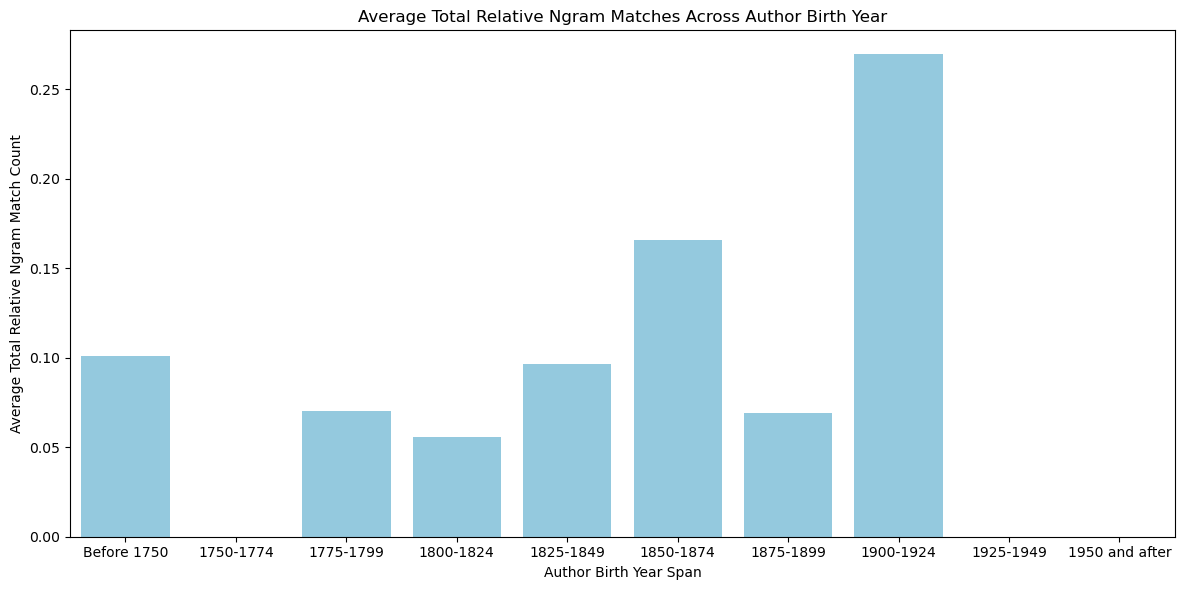

Visualizing Ngram Stats (Highest Year Match, Most Recent Year Match, etc.)...


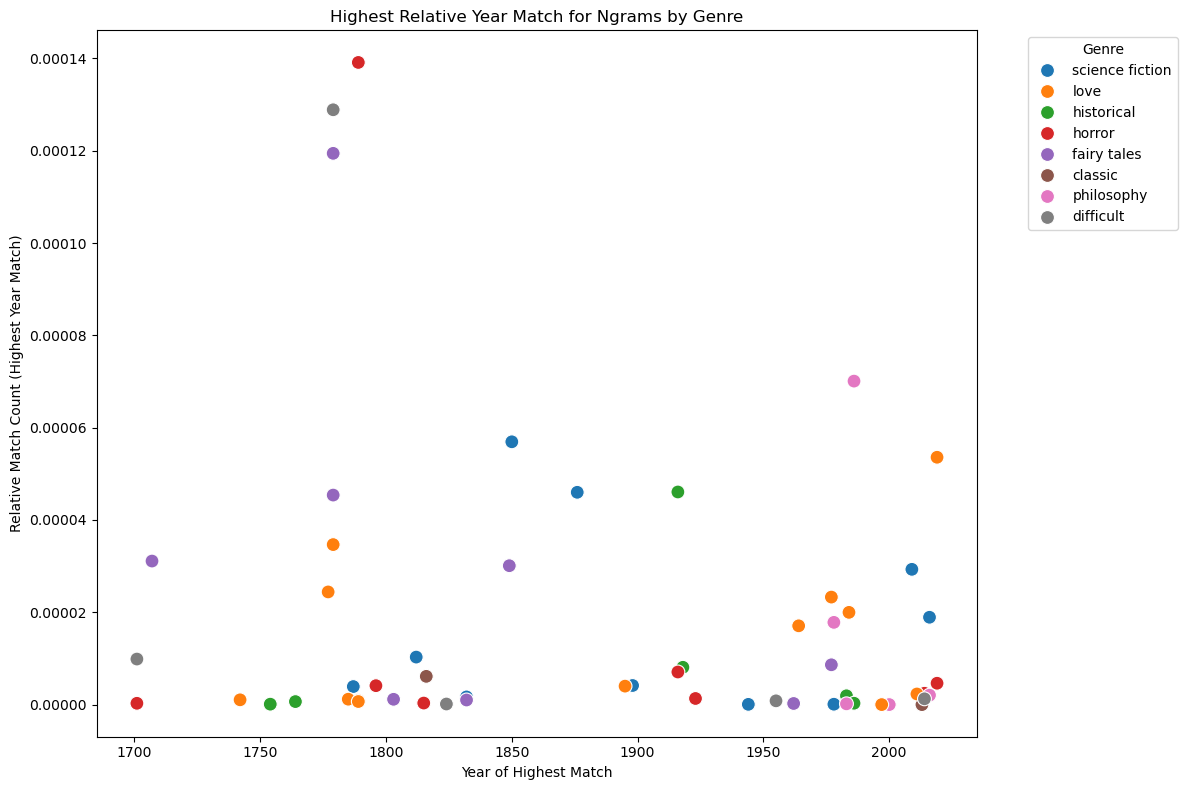

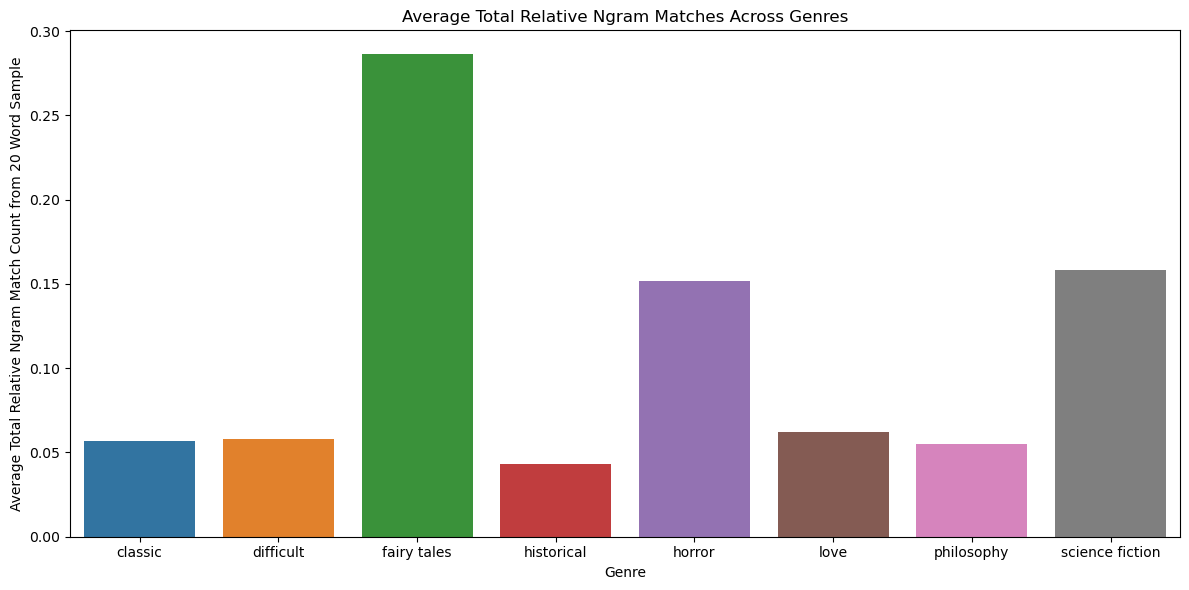

Visualizing Ngram Stats by Reading Difficulty...


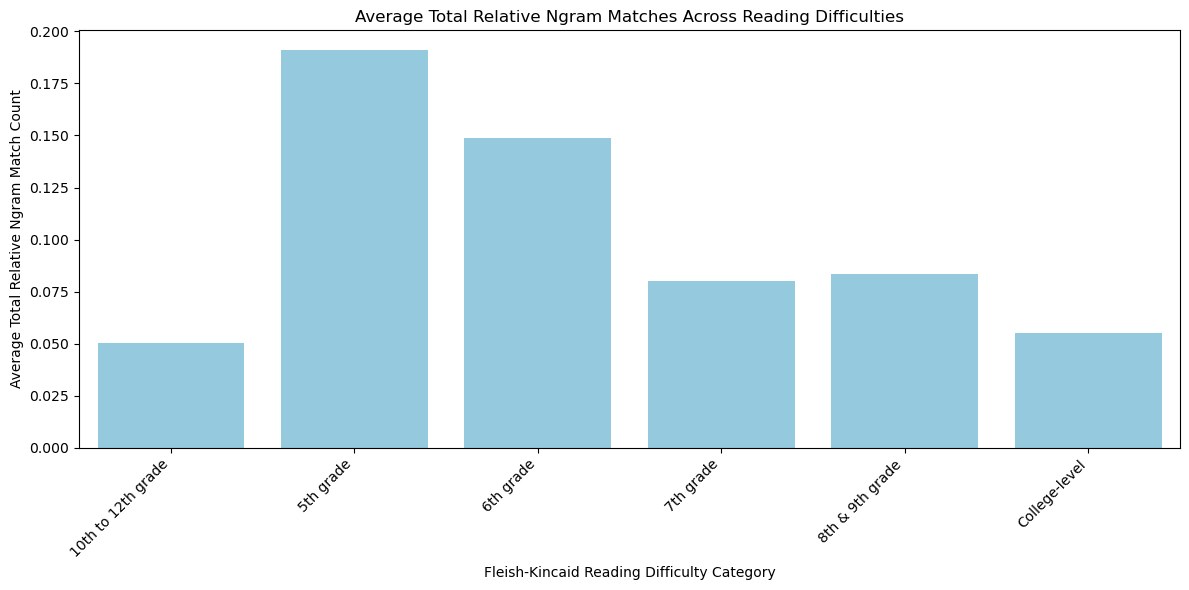

Visualizing Scatter by Reading Ease and Genre...


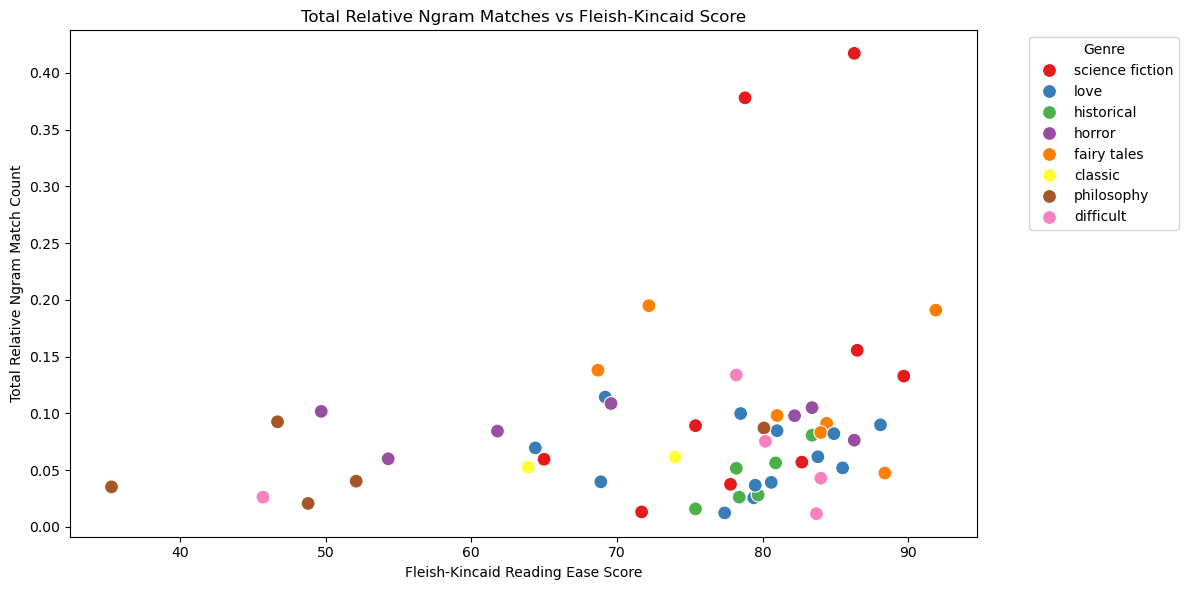

In [435]:
visualize_ngram_stats_on_processed_books(processed_books)

## TFIDF

In [476]:
def word_pos_tokenize(sentence):
    # Takes a sentence and returns the part of speech tags for the sentence
    sentence_pos = [word_pos[1] for word_pos in nltk.pos_tag(nltk.word_tokenize(sentence))[:-1]]
    return sentence_pos
    
def word_pos_tokenize_general(sentence):
    # Takes a sentence and returns the generalized part of speech tags for the sentence
    sentence_pos = [word_pos[1][0] for word_pos in nltk.pos_tag(nltk.word_tokenize(sentence))[:-1]]
    return sentence_pos

def word_iob_tokenize(sentence):
    # Takes a sentence and returns the iob tags for the sentence
    grammar = r"""
              NP: {<DT>?<JJ>*<NN.*>}              # Noun Phrase: Optional determiner, adjectives, and nouns
              VP: {<VB.*><NP|PP|CLAUSE>+}          # Verb Phrase: Verb followed by a noun phrase or clause
              PP: {<IN><NP>}                       # Prepositional Phrase: Preposition followed by a noun phrase
              CLAUSE: {<NP><VP>}                   # Clause: Noun Phrase followed by Verb Phrase
            """
    cp = nltk.RegexpParser(grammar)
    sentence = nltk.pos_tag(nltk.word_tokenize(sentence))[:-1]
    sentence_trees = cp.parse(sentence)
    phrases_and_clauses = [subtree.label() for subtree in sentence_trees.subtrees()]
    return phrases_and_clauses

In [478]:
def tfidf_pos(corpus, tokenizer):
    # Takes a corpus and returns the number for which each sentence differs from the next as determined by tfidf of word type
    tfidf_sent = nltk.sent_tokenize(corpus)
    vec = TfidfVectorizer(tokenizer = tokenizer) 
    tfidf = vec.fit_transform(tfidf_sent)
    pd.DataFrame(tfidf.todense())
    diags = np.diagonal((tfidf @ tfidf.T).todense(), offset = 1)
    return({'Mean': np.mean(diags), 'SD':np.std(diags)})

In [482]:
# Get tfidf stats
tfidf_stats = {}
for x in cleaned_books:
    if x['cleaned_text']:  # Check if the cleaned_text is not empty
        tfidf_stats[x['title']] = {
            'POS': tfidf_pos(x['cleaned_text'], word_pos_tokenize),
            'POS_general': tfidf_pos(x['cleaned_text'], word_pos_tokenize_general),
            'IOB': tfidf_pos(x['cleaned_text'], word_iob_tokenize)
        }

In [490]:
# Save
with open("data/tfidf_stats.pkl", "wb") as f:
    pickle.dump(tfidf_stats, f)

In [492]:
# Load
with open("data/tfidf_stats.pkl", "rb") as f:
    tfidf_stats = pickle.load(f)

## Datayze

In [500]:
import requests_cache

requests_cache.install_cache('my_cache', expire_after=3600)

In [502]:
# Get word details from datayze
def get_datayze(corpus):
    # Get stop words to ignore
    stopwords = nltk.corpus.stopwords.words("english")
    # Match all words, ignoring numbers and single characters
    words = re.findall(r"[a-zA-Z\-\'’]{2,}|[aAiI]", corpus)
    # Remove ending possessive suffixes
    words = [re.sub(r"\'s$|’s$|s’$|s\'$", "", word) for word in words]
    # Make words lowercase
    words = [w.lower() for w in words if w.lower() not in stopwords]
    # Get words that have an at most 5% chance of appearing according to zipfs law
    fq = nltk.FreqDist(words)
    lastind = len(fq) - (len(fq)//100)
    top_words = [x[0] for x in fq.most_common(lastind)[lastind-100:lastind]]
    words_details = {}
    # Scrape the rank number and yes/no string corresponding to whether the word is misspelled or a name 
    for x in top_words:
        time.sleep(0.05)
        datayze = lx.fromstring(requests.get("https://datayze.com/word-analyzer?word=" + x).text)
        try:
            word_rank = re.findall(r"^[-\d]+", datayze.xpath('//*[@id="word_rank"]/text()')[0])[0]
        except:
            word_rank = "-"
        try:
            word_misspelled = datayze.xpath('//tr/td[text() = "Misspelled:"]/following-sibling::td/span/text()')[0].rstrip()
        except:
            word_misspelled = "Yes"
        try:
            word_name = datayze.xpath('//tr/td[text() = "Name:"]/following-sibling::td//text()[last()]')[0].rstrip()
        except:
            word_name = "No"
                 
        # Create and return dicitonary for details from datayze
        words_details[x] = {'Rank': word_rank,
                        'Misspelled': word_misspelled,
                        'Name': word_name}
    return(words_details)

In [504]:
# Scrape for all books
datayze_stats = {}
for x in cleaned_books:
    datayze_stats[x['title']] = {'Datayze': get_datayze(x['cleaned_text'])}

In [506]:
# Aggregate statistics from scraped datayze data
datayze_stats_summary = {}
for book in datayze_stats:
    rank = []
    rank_missing_count = 0
    misspelled_count = 0
    name_count = 0
    for word in datayze_stats[book]['Datayze']:
        if datayze_stats[book]['Datayze'][word]['Rank'] == '-':
            rank_missing_count += 1
        else:
            rank.append(int(datayze_stats[book]['Datayze'][word]['Rank']))
        if datayze_stats[book]['Datayze'][word]['Misspelled'] == 'Yes':
            misspelled_count += 1
        if datayze_stats[book]['Datayze'][word]['Name'] == 'Yes':
            name_count += 1
    datayze_stats_summary[book] = {'Rank': np.mean(rank),
                                   'Rank Missing': rank_missing_count,
                                   'Misspelled': misspelled_count, 
                                   'Name': name_count}

In [528]:
# Save
with open("data/datayze_stats.pkl", "wb") as f:
    pickle.dump(datayze_stats, f)

In [530]:
# Load
with open("data/datayze_stats.pkl", "rb") as f:
    datayze_stats = pickle.load(f)

## Zipf Deviance

In [508]:
# Calculate positive difference between obsesrved frequency of each word and theoretical frequency according to Zipf's law
def get_zipf(corpus):
    # Get stop words to ignore
    stopwords = nltk.corpus.stopwords.words("english")
    # Match all words, ignoring numbers and single characters
    words = re.findall(r"[a-zA-Z\-\'’]{2,}|[aAiI]", corpus)
    # Remove ending possessive suffixes
    words = [re.sub(r"\'s$|’s$|s’$|s\'$", "", word) for word in words]
    # Make words lowercase
    #words = [w.lower() for w in words if w.lower() not in stopwords]
    # Get frequency distributiono
    fq = nltk.FreqDist(words)
    # Scrape the rank number and yes/no string corresponding to whether the word is misspelled or a name 
    logFreq = [np.log(i) for _, i in fq.most_common()]
    logRank = [np.log(1 + i) for i in range(len(fq))]
    logTheo = [np.log(1/(1 + i)) for i in range(len(fq))] + logFreq[0]
    sum_zipf_diff = 0
    for i in range(len(fq)):
        sum_zipf_diff += logFreq[i]-logTheo[i]
    return(sum_zipf_diff/len(fq))

In [510]:
# Get Zipf's law differences for all books
zipf_stats = {}
for x in cleaned_books:
    zipf_stats[x['title']] = {'Zipf Difference': get_zipf(x['cleaned_text'])}

In [536]:
# Save
with open("data/zipf_stats.pkl", "wb") as f:
    pickle.dump(zipf_stats, f)

In [538]:
# Load
with open("data/zipf_stats.pkl", "rb") as f:
    zipf_stats = pickle.load(f)

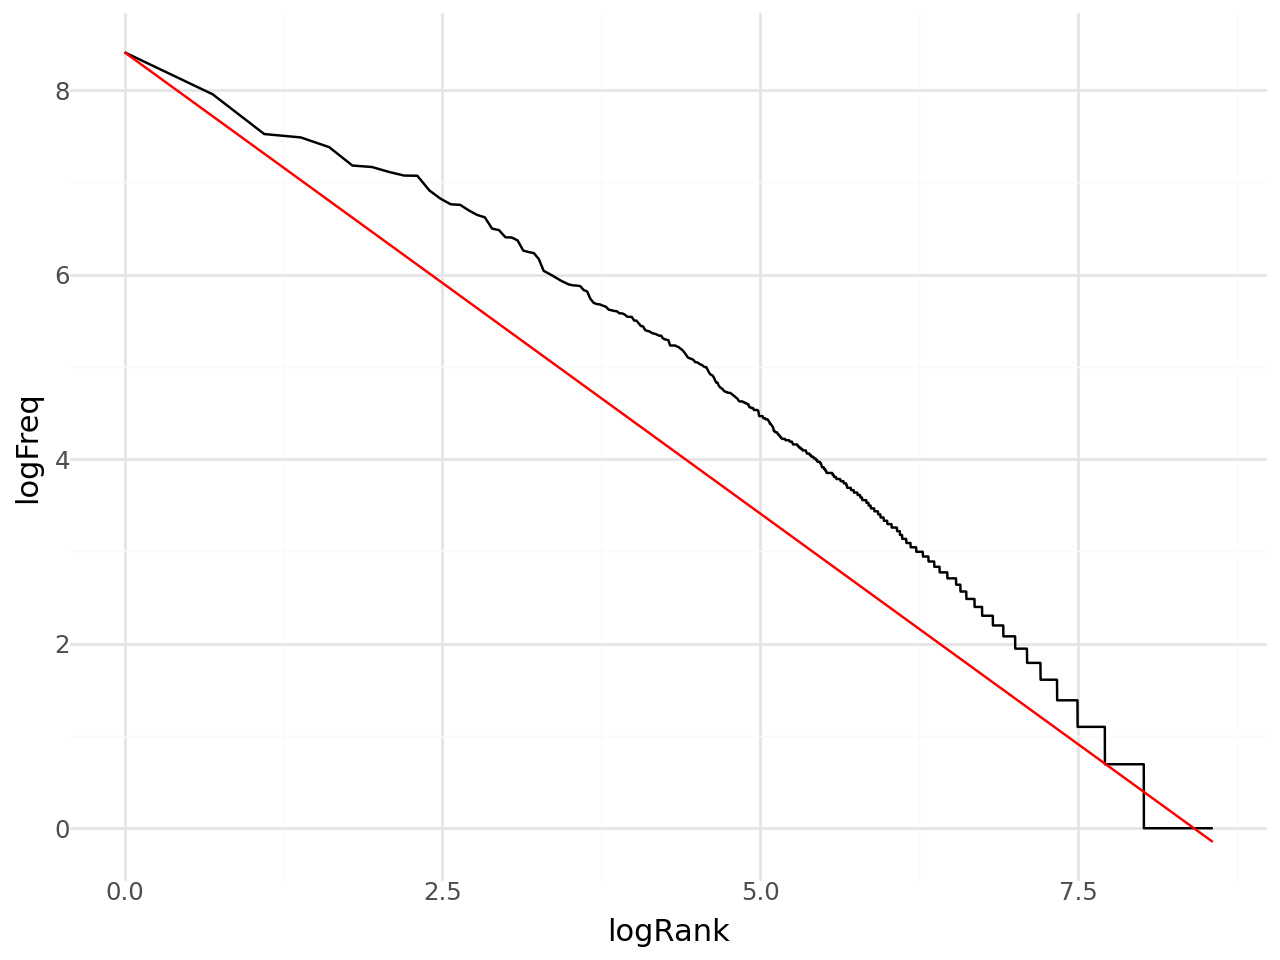

In [512]:
# Get stop words to ignore
#stopwords = nltk.corpus.stopwords.words("english")
# Match all words, ignoring numbers and single characters
words = re.findall(r"[a-zA-Z\-\'’]{2,}|[aAiI]", cleaned_books[-1]['cleaned_text'])
# Remove ending possessive suffixes
words = [re.sub(r"\'s$|’s$|s’$|s\'$", "", word) for word in words]
# Make words lowercase
#words = [w.lower() for w in words if w.lower() not in stopwords]
# Get frequency distributiono
fq = nltk.FreqDist(words)
logFreq = [np.log(i) for _, i in fq.most_common()]
logRank = [np.log(1 + i) for i in range(len(fq))]
logTheo = [np.log(1/(1 + i)) for i in range(len(fq))] + logFreq[0]
logFreq[0]
(
p9.ggplot() + p9.theme_minimal() + 
    p9.geom_line(p9.aes(x='logRank', y='logFreq')) + 
    p9.geom_line(p9.aes(x='logRank', y='logTheo'), color = 'red') 
)

In [514]:
# Evaluating percentage for Zipf's law distribution
x = 100000
sum_num = 0
for i in range(x//20):
    sum_num += 1/(x-i)
sum_num

0.05129303123055607

## Stream of Consciousness

In [520]:
# Get length of each paragraph in character number
def get_parlength(corpus):
    # Match all characters before a line break
    pars = re.findall(r"(\S.*?) \r\n", corpus)
    time.sleep(0.05)
    # Get the average length of each paragraph
    avg_par = sum([len(x) for x in pars]) / len(pars)
    return(avg_par)

In [522]:
# Collect data of paragraph length
parlength_stats = {}
for x in cleaned_books:
    parlength_stats[x['title']] = {'Paragraph Length': get_parlength(x['cleaned_text'])}

In [540]:
# Save
with open("data/parlength_stats.pkl", "wb") as f:
    pickle.dump(parlength_stats, f)

In [542]:
# Load
with open("data/parlength_stats.pkl", "rb") as f:
    parlength_stats = pickle.load(f)

In [524]:
# Get number of sentences per paragraph in character number
def get_sentperpar(corpus):
    # Match all characters before a line break
    pars = re.findall(r"(\S.*?) \r\n", corpus)
    sentperpars = []
    for par in pars:
        puncnum = re.findall(r"[\.\?\!]+", par)
        sentperpars.append(len(puncnum) / len(par))
    # Get the average length of each paragraph
    avg_sentperpar = sum(sentperpars) / len(sentperpars)
    return(avg_sentperpar)

In [526]:
# Collect data of sentences per paragraph
sentperpar_stats = {}
for x in cleaned_books:
    sentperpar_stats[x['title']] = {'Sentence Count': get_sentperpar(x['cleaned_text'])}

## Hapaxes

In [532]:
# Get the proportion of hapaxes for each book
def get_hapaxes(corpus):
    # Get stop words to ignore
    stopwords = nltk.corpus.stopwords.words("english")
    # Match all words, ignoring numbers and single characters
    words = re.findall(r"[a-zA-Z\-\'’]{2,}|[aAiI]", corpus)
    # Remove ending possessive suffixes
    words = [re.sub(r"\'s$|’s$|s’$|s\'$", "", word) for word in words]
    # Make words lowercase
    words = [w.lower() for w in words if w.lower() not in stopwords]
    # Get frequency distributiono
    fq = nltk.FreqDist(words)
    # Return proportion of hapaxes
    return(len(fq.hapaxes())/len(fq))

In [534]:
# Run function over books
hapax_stats = {}
for x in cleaned_books:
    hapax_stats[x['title']] = {'Hapax Ratio': get_hapaxes(x['cleaned_text'])}

In [544]:
# Save
with open("data/hapax_stats.pkl", "wb") as f:
    pickle.dump(hapax_stats, f)

In [546]:
# Load
with open("data/hapax_stats.pkl", "rb") as f:
    hapax_stats = pickle.load(f)

## Plots

In [548]:
# Process data for visualization
for i in range(len(processed_books)):
    book = processed_books[i]
    processed_books[i]['TFIDF POS Mean'] = tfidf_stats[book['title']]['POS']['Mean']
    processed_books[i]['TFIDF POS SD'] = tfidf_stats[book['title']]['POS']['SD']
    processed_books[i]['TFIDF POS General Mean'] = tfidf_stats[book['title']]['POS_general']['Mean']
    processed_books[i]['TFIDF POS General SD'] = tfidf_stats[book['title']]['POS_general']['SD']
    processed_books[i]['TFIDF IOB Mean'] = tfidf_stats[book['title']]['IOB']['Mean']
    processed_books[i]['TFIDF IOB SD'] = tfidf_stats[book['title']]['IOB']['SD']
    processed_books[i]['Datayze Rank'] = datayze_stats_summary[book['title']]['Rank']
    processed_books[i]['Datayze Rank Missing'] = datayze_stats_summary[book['title']]['Rank Missing']
    processed_books[i]['Datayze Misspelled'] = datayze_stats_summary[book['title']]['Misspelled']
    processed_books[i]['Datayze Name'] = datayze_stats_summary[book['title']]['Name']
    processed_books[i]['Zipf Difference'] = zipf_stats[book['title']]['Zipf Difference']
    processed_books[i]['Hapax Ratio'] = hapax_stats[book['title']]['Hapax Ratio']

In [550]:
# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(processed_books)

# Extract 'totalRelMatchCount' from the 'ngram_stats' dictionary and add it as a separate column
df['mostRecentRelMatch'] = df['ngram_stats'].apply(lambda x: x['mostRecentRelMatch']['relMatchCount'])
df['Flesch-Kincaid Score'] = pd.to_numeric(df['reading_ease_score'], errors = 'coerce')

#df['TFIDF POS'] = df['TFIDF'].apply(lambda x: x['POS']['Mean'])
#df['TFIDF POS General'] = df['TFIDF'].apply(lambda x: x['POS General']['Mean'])
#df['TFIDF IOB'] = df['TFIDF'].apply(lambda x: x['IOB']['Mean'])
#df['Datayze Rank'] = df['Datayze'].apply(lambda x: x['Rank'])
#df['Zipf Difference'] = df['Zipf'].apply(lambda x: x['Difference'])
#df['Hapax Ratio'] = df['Hapax'].apply(lambda x: x['Ratio'])

# Select relevant columns to keep
df = df[['title', 'mostRecentRelMatch', 'TFIDF POS Mean', 'TFIDF POS General Mean', 'TFIDF IOB Mean', 'Datayze Rank',
         'Datayze Rank Missing', 'Datayze Misspelled', 'Datayze Name',
         #'TFIDF POS SD', 'TFIDF POS General SD', 'TFIDF IOB SD',
         'Zipf Difference', 'Hapax Ratio', 'Flesch-Kincaid Score']]


# Define a dictionary for column color scale direction
color_direction = {
    'mostRecentRelMatch': 'green_to_red',  # Green to Red for this column
    'TFIDF POS Mean': 'red_to_green',      # Red to Green for this column
    'TFIDF POS General Mean': 'red_to_green',
    'TFIDF IOB Mean': 'red_to_green',
    #'TFIDF POS SD': 'red_to_green',      
    #'TFIDF POS General SD': 'red_to_green',
    #'TFIDF IOB SD': 'red_to_green',
    'Datayze Rank': 'red_to_green',
    'Datayze Rank Missing': 'red_to_green',
    'Datayze Misspelled': 'red_to_green',
    'Datayze Name': 'green_to_red',
    'Zipf Difference': 'green_to_red',
    'Hapax Ratio': 'green_to_red',
    'Flesch-Kincaid Score': 'green_to_red'
}

# Function to apply color to the cells based on column's direction
def color_cells(val, col, df):
    # Normalize value for coloring
    norm_val = (val - df[col].min()) / (df[col].max() - df[col].min())
    
    if color_direction[col] == 'green_to_red':
        color = plt.cm.RdYlGn(norm_val)  # Use the RdYlGn color scale from green to red
    elif color_direction[col] == 'red_to_green':
        color = plt.cm.RdYlGn_r(norm_val)  # Reverse the color scale to red to green
        
    return f'background-color: rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})'

# Function to apply color styling to the dataframe column-wise
def apply_column_style(col, df):
    return col.apply(lambda val: color_cells(val, col.name, df))

# Now apply color styles to the numeric columns (excluding 'title')
styled_df = df.style.apply(apply_column_style, subset=df.columns.difference(['title']), df=df)

# Display the styled DataFrame (works well in Jupyter Notebooks)
styled_df

# Filter the rows based on specific titles (e.g., filtering for titles 'Book1' and 'Book3')
filtered_titles = ['Ulysses', 'Paradise Lost', 'The Critique of Pure Reason', 'Les Misérables',
                   'The Picture of Dorian Gray', 'The Story of the Three Little Pigs', '2 B R 0 2 B']
filtered_df = df[df['title'].isin(filtered_titles)]
filtered_df = filtered_df.set_index('title').reindex(filtered_titles).reset_index()

# Apply the styling again to the filtered DataFrame (to preserve styling in the output)
filtered_styled_df = filtered_df.style.apply(apply_column_style, subset=filtered_df.columns.difference(['title']), df=df)

# Display the filtered DataFrame with the styling applied
filtered_styled_df

,title,mostRecentRelMatch,TFIDF POS Mean,TFIDF POS General Mean,TFIDF IOB Mean,Datayze Rank,Datayze Rank Missing,Datayze Misspelled,Datayze Name,Zipf Difference,Hapax Ratio,Flesch-Kincaid Score
0,Ulysses,0.000000,0.362658,0.493374,0.725591,6047.272727,67,63,8,0.565569,0.544367,83.700000
1,Paradise Lost,0.000012,0.711023,0.819008,0.915998,4172.492063,37,36,5,1.180645,0.520456,45.700000
2,The Critique of Pure Reason,0.000037,0.677034,0.787603,0.893333,4104.628205,22,22,3,-0.496690,0.399138,35.300000
3,Les Misérables,0.000000,0.492192,0.636632,0.772704,6717.507937,37,37,0,-0.203727,0.408328,79.700000
4,The Picture of Dorian Gray,0.000006,0.457016,0.611379,0.727825,4833.800000,20,20,7,0.649044,0.507581,84.000000
5,The Story of the Three Little Pigs,0.000188,0.457980,0.546202,0.721536,1381.933333,10,7,10,1.112447,0.601093,86.800000
6,2 B R 0 2 B,0.000059,0.370374,0.509956,0.694652,1888.838710,7,7,4,1.537188,0.728693,86.300000


In [552]:
styled_df

,title,mostRecentRelMatch,TFIDF POS Mean,TFIDF POS General Mean,TFIDF IOB Mean,Datayze Rank,Datayze Rank Missing,Datayze Misspelled,Datayze Name,Zipf Difference,Hapax Ratio,Flesch-Kincaid Score
0,"Frankenstein; Or, The Modern Prometheus",0.000000,0.581213,0.735413,0.844597,4160.385542,17,17,0,0.572402,0.442369,65.000000
1,The Strange Case of Dr. Jekyll and Mr. Hyde,0.000008,0.595508,0.741319,0.849704,3803.305263,5,5,0,0.672810,0.582854,75.400000
2,The War of the Worlds,0.000001,0.538657,0.688398,0.817143,5421.152941,15,15,4,0.317997,0.494510,77.800000
3,Twenty Thousand Leagues under the Sea,0.000000,0.528190,0.687460,0.816551,4686.298701,23,23,6,0.126277,0.465908,71.700000
4,2 B R 0 2 B,0.000059,0.370374,0.509956,0.694652,1888.838710,7,7,4,1.537188,0.728693,86.300000
5,Anthem,0.000011,0.512723,0.665150,0.731252,3293.709677,7,7,11,0.475294,0.458288,89.700000
6,The Eyes Have It,0.000071,0.422720,0.557021,0.731845,2680.959184,2,2,6,1.437283,0.758537,78.800000
7,We,0.000002,0.451016,0.588596,0.746114,5968.851852,19,19,1,0.501059,0.460141,82.700000
8,A Pail of Air,0.000036,0.498005,0.665196,0.772266,3146.404255,6,5,5,1.035977,0.610961,86.500000
9,Corsairs of the cosmos,0.000001,0.421636,0.582913,0.760073,3374.791209,9,9,3,0.995392,0.555957,nan


In [554]:
# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(processed_books)

# Extract 'totalRelMatchCount' from the 'ngram_stats' dictionary and add it as a separate column
df['mostRecentRelMatch'] = df['ngram_stats'].apply(lambda x: x['mostRecentRelMatch']['relMatchCount'])
df['Flesch-Kincaid Score'] = pd.to_numeric(df['reading_ease_score'], errors = 'coerce')
df['Genre'] = df['tag']
df['Title'] = df['title']

# Select relevant columns to keep
df = df[['title', 'Genre', 'mostRecentRelMatch', 'TFIDF POS Mean', 'TFIDF POS General Mean', 'TFIDF IOB Mean', 'Datayze Rank',
        'Zipf Difference', 'Hapax Ratio', 'Flesch-Kincaid Score']]

def visualize_scatter_by_reading_ease_and_genre(df, stat = "TFIDF POS Mean"):
    
    

    # drop NaN values in 'Reading Ease Score' or 'Total RelMatch Count'
    df = df.dropna(subset=['Flesch-Kincaid Score', stat])

    # plot the scatterplot with colored points based on genre
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="Flesch-Kincaid Score", y=stat, data=df, hue="Genre", palette="Set1", s=100)

    plt.title(stat+ ' vs Flesch-Kincaid Score (Colored by Genre)')
    plt.xlabel('Flesch-Kincaid Score')
    plt.ylabel(stat)

    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.plot()


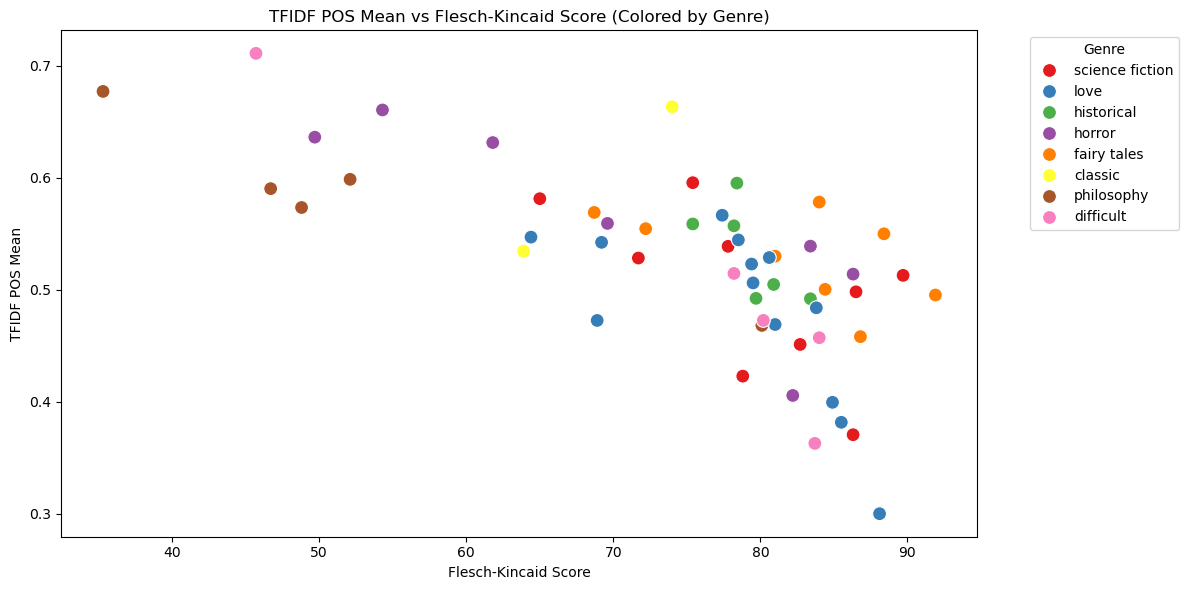

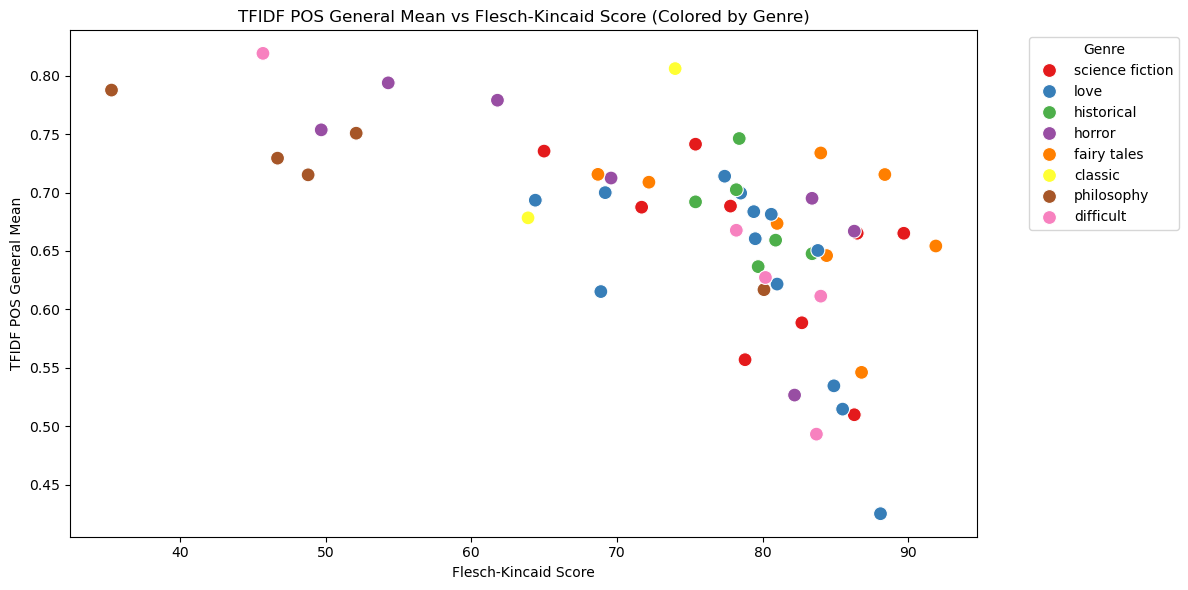

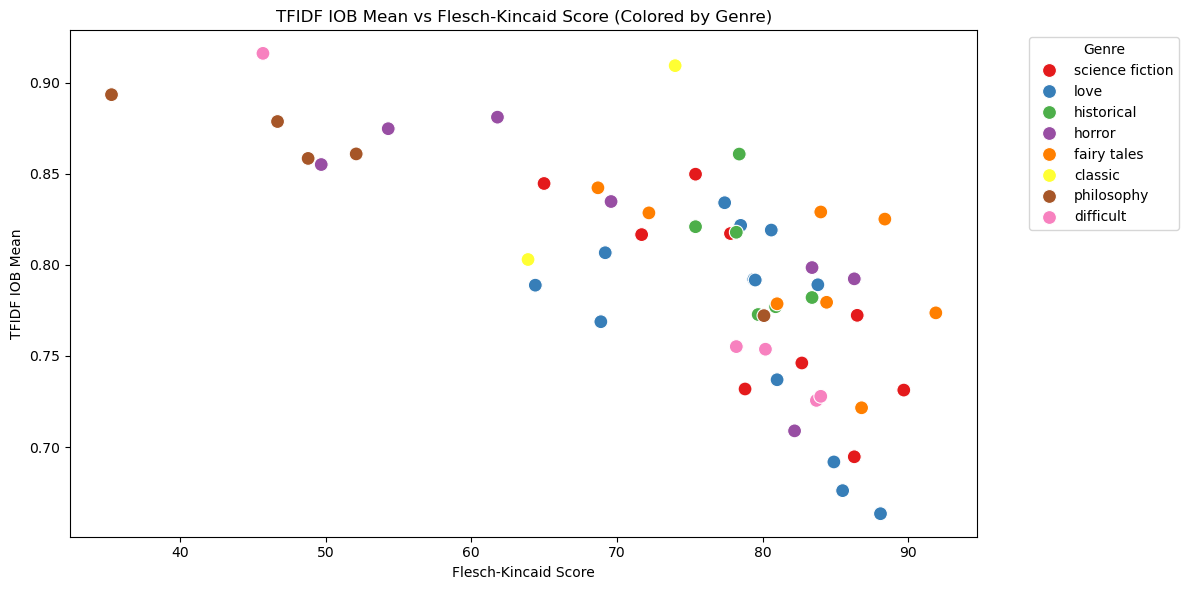

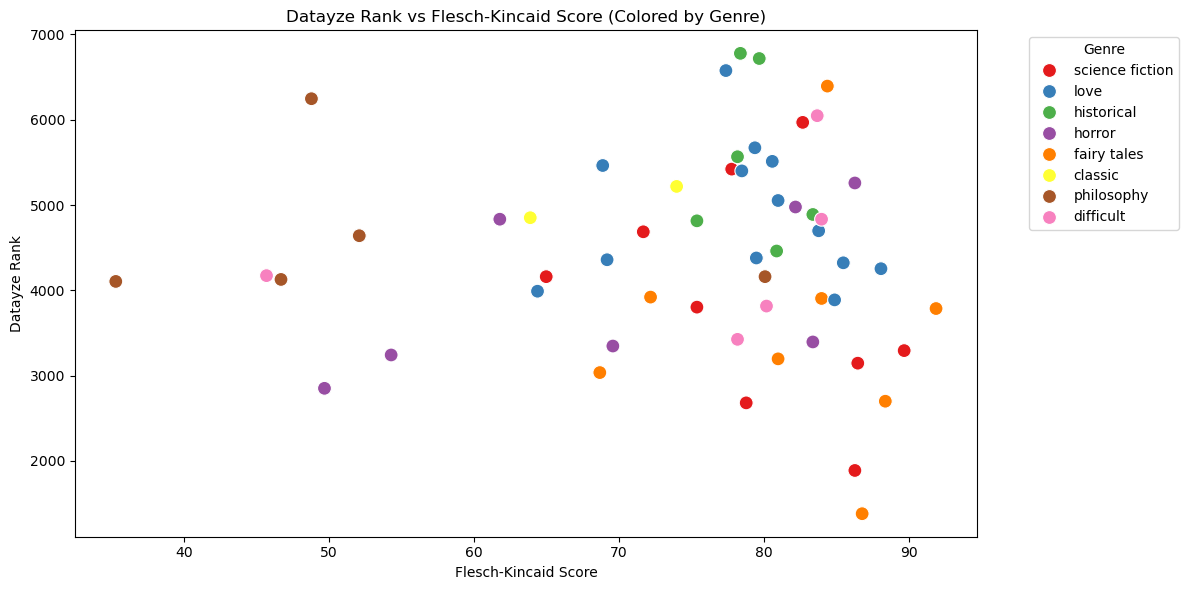

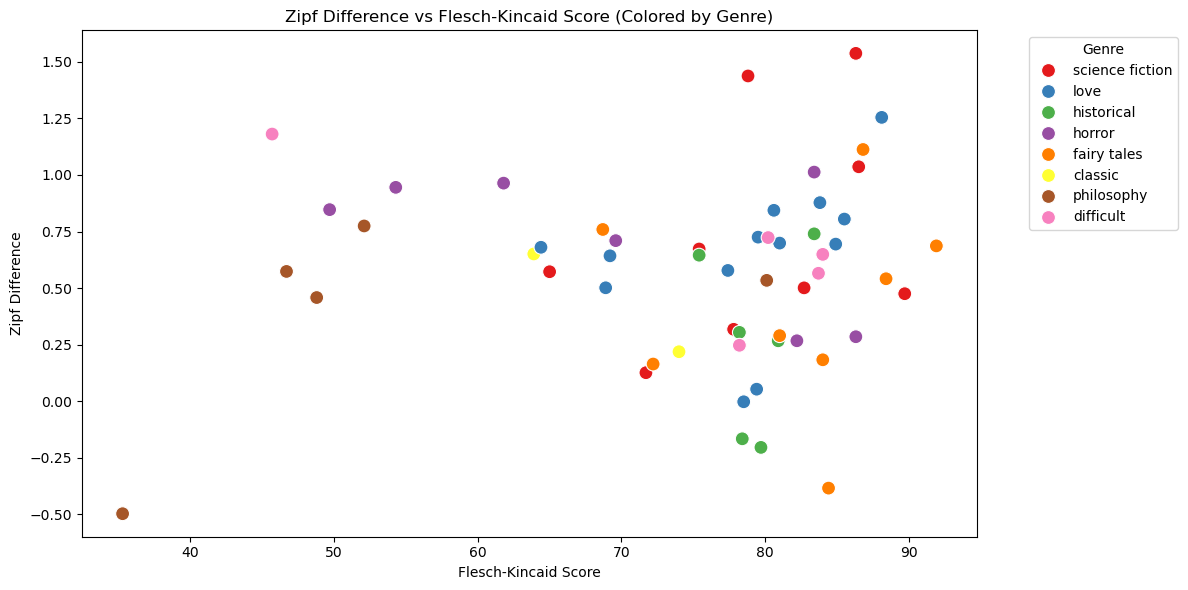

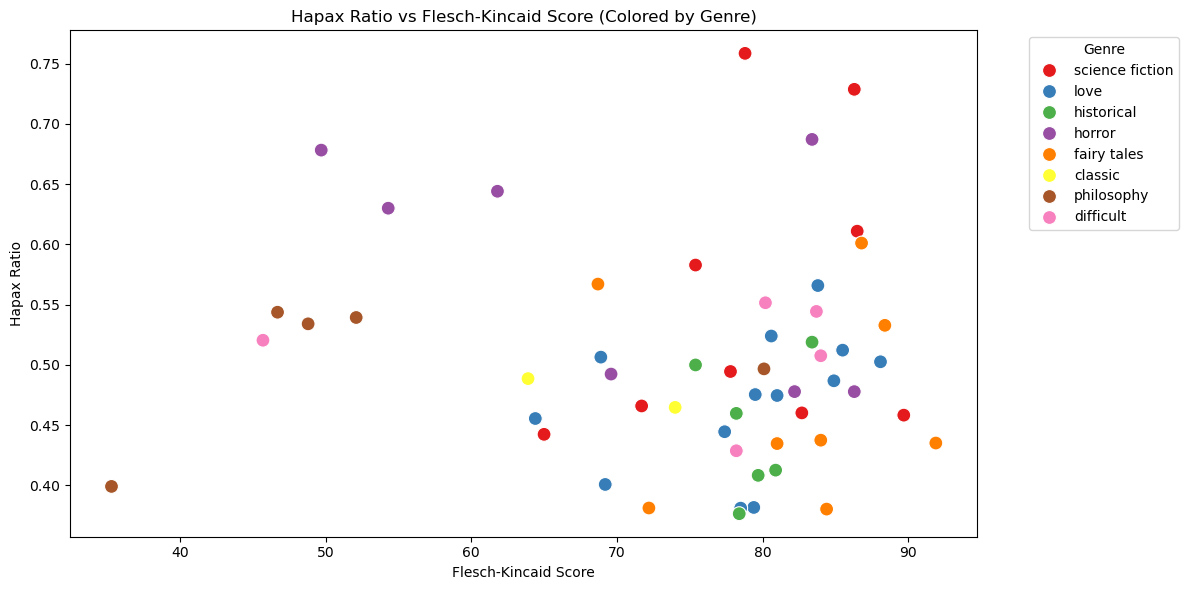

In [566]:
stat_list = ['TFIDF POS Mean', 'TFIDF POS General Mean', 'TFIDF IOB Mean', 'Datayze Rank', 'Zipf Difference', 'Hapax Ratio']

for x in stat_list:
    visualize_scatter_by_reading_ease_and_genre(df, stat = x)
    plt.savefig("results/scatter_plot_Flesch-Kincaid_vs_"+x+".png", format='png', dpi=300)

In [558]:
def visualize_stats(df, stat):
    
    # drop NaN values in 'Reading Ease Score' or 'Total RelMatch Count'
    df = df.dropna(subset=['Flesch-Kincaid Score', stat])
    
    # calculate average relmatch count by genre
    genre_avg_stat = df.groupby('Genre').agg({stat: 'mean'}).reset_index()
    
    # plot: highest year match (relmatch count) - scatter plot with colored points based on genre
    plt.figure(figsize=(12, 8))

    # plot average total relmatch count per genre
    sns.barplot(x="Genre", y=stat, data=genre_avg_stat, hue="Genre", palette="tab10")
    plt.title(stat + ' Across Genres')
    plt.ylabel(stat)
    plt.xlabel('Genre')
    
    plt.tight_layout()
    plt.plot()


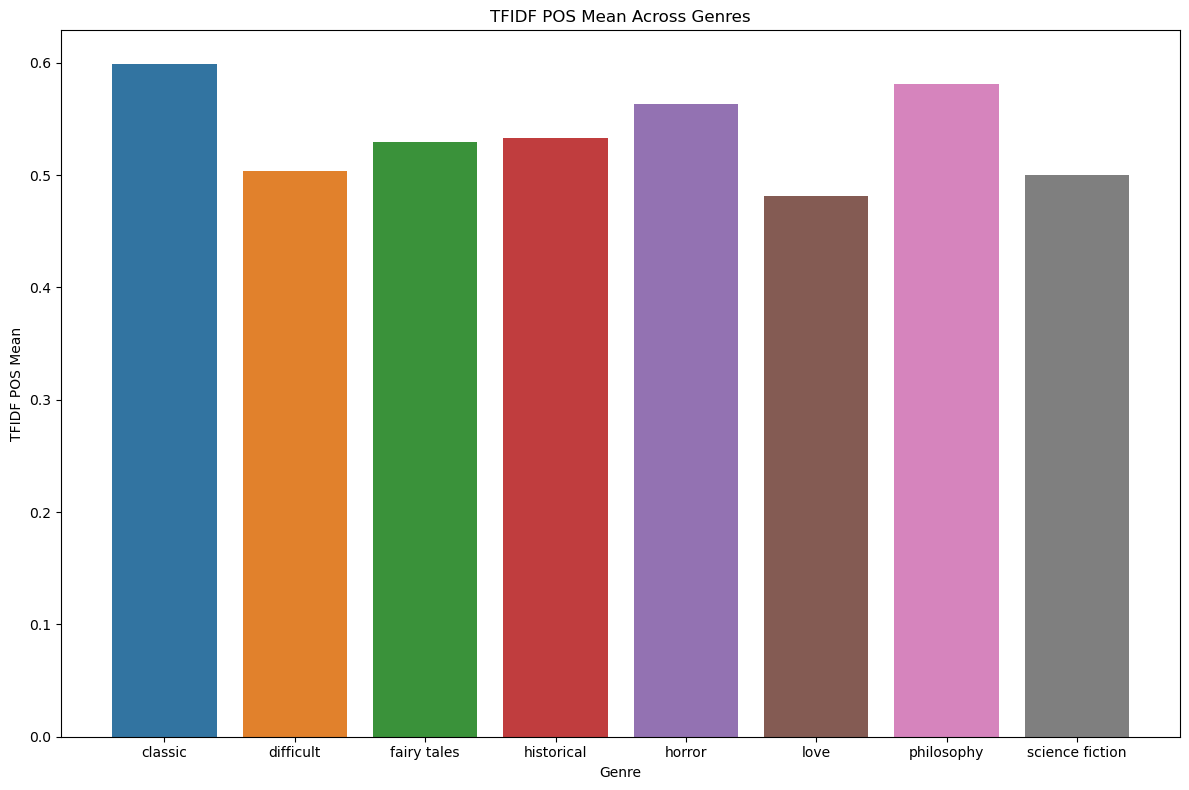

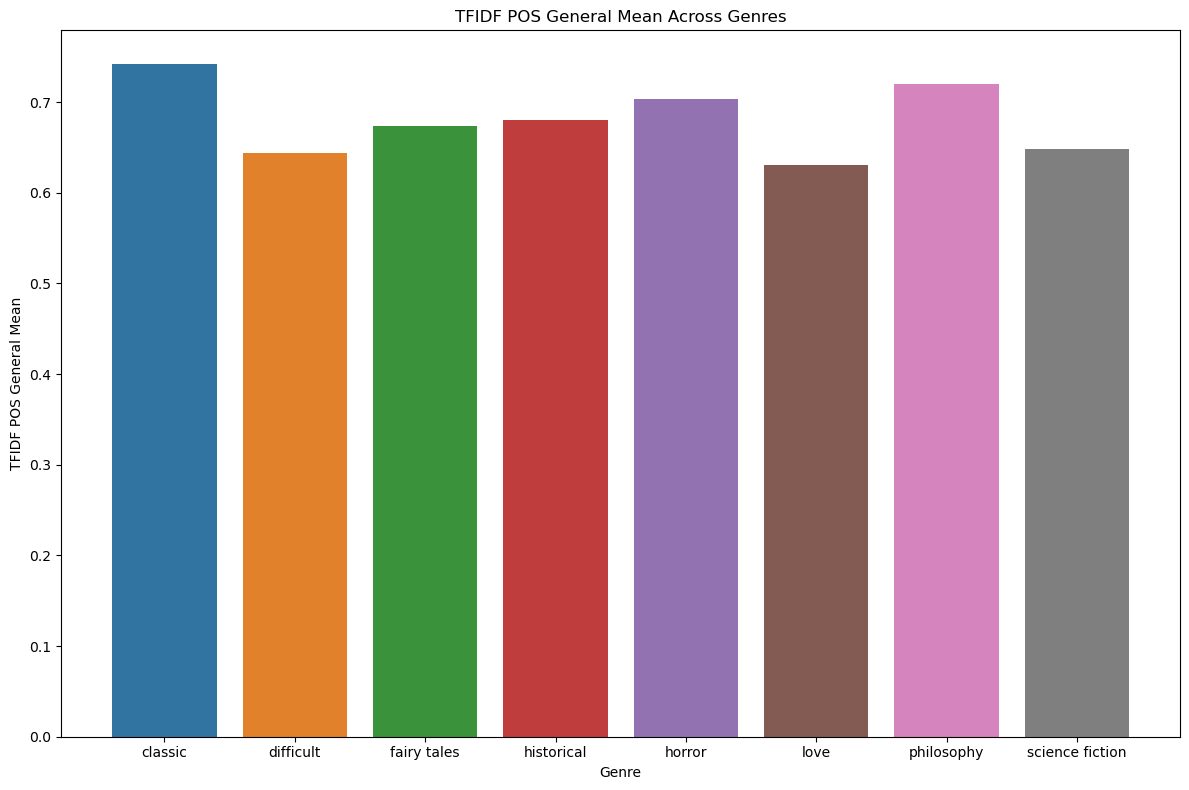

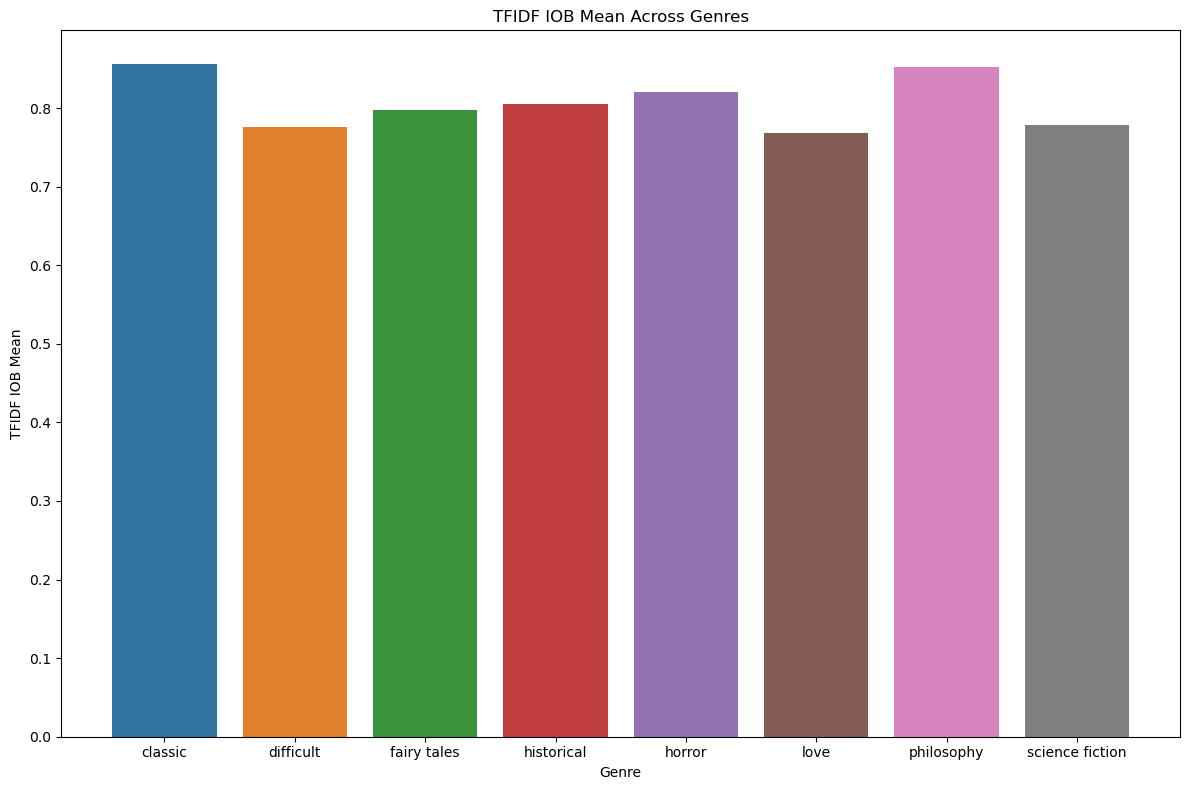

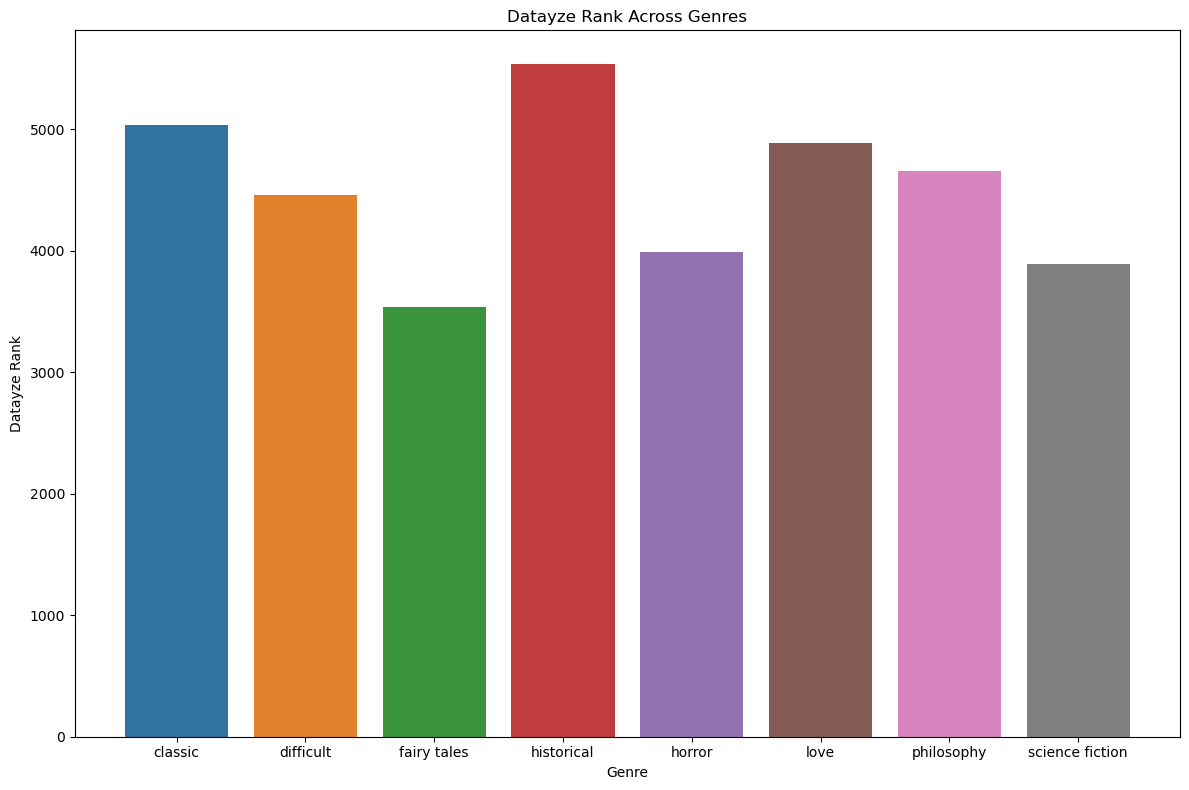

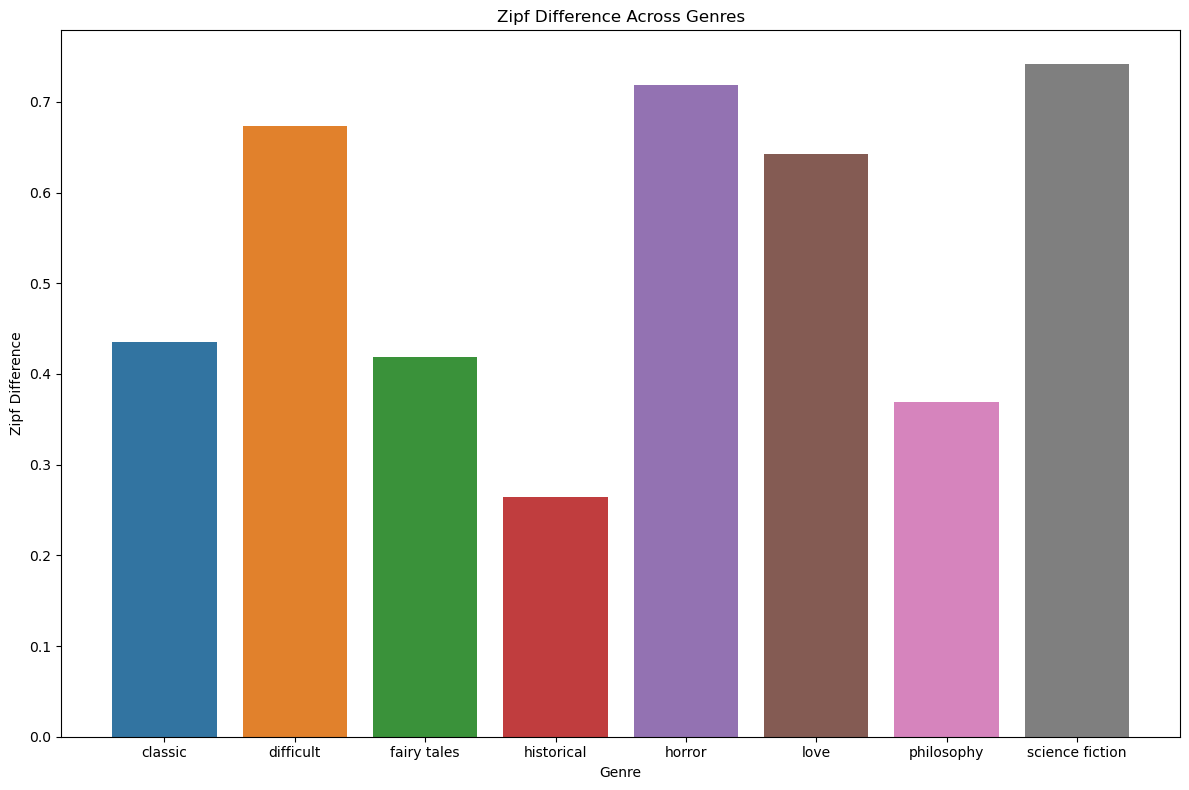

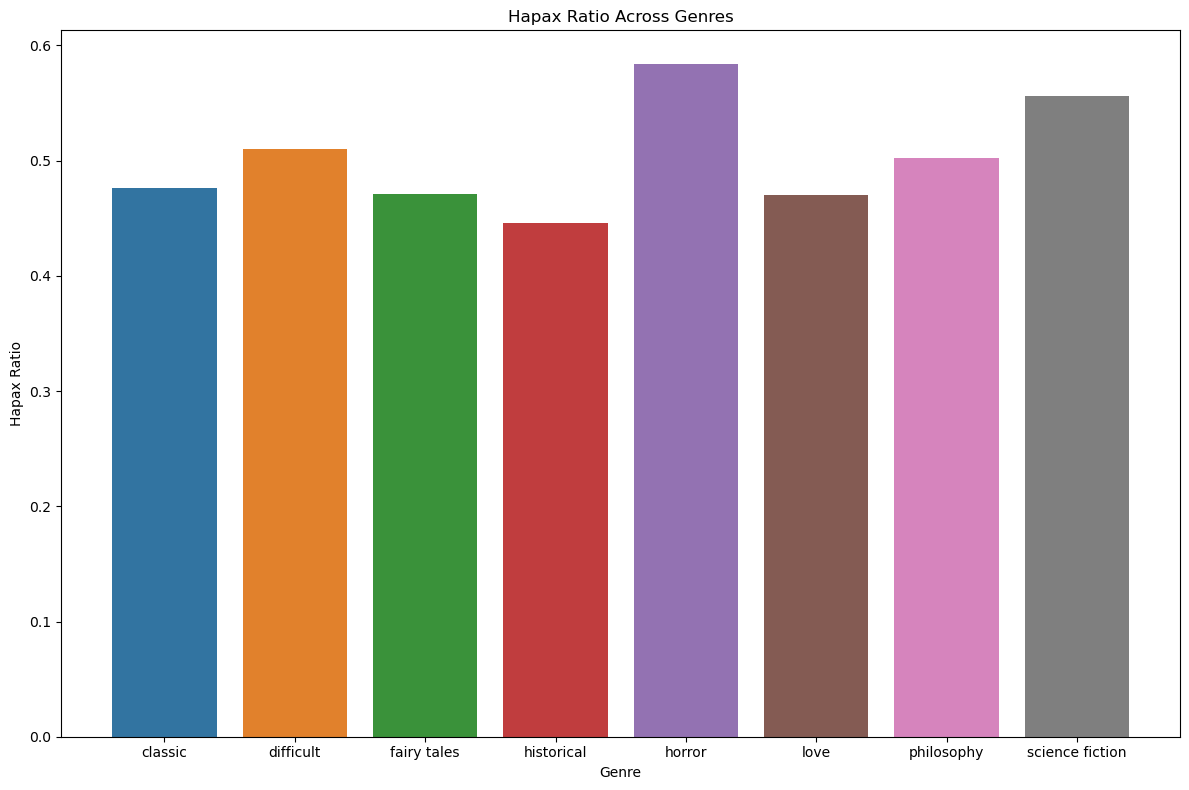

In [564]:
for x in stat_list:
    visualize_stats(df, stat = x)
    plt.savefig("results/bar_plot_"+x+".png", format='png', dpi=300)